# Imports

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
import multiprocessing as mp
import seaborn as sns
sns.set_theme(style="whitegrid")

from pprint import pprint
from matplotlib import pyplot as plt

from used_car_price.config import config
from used_car_price.processing import data_management
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from feature_engine import categorical_encoders as ce
from feature_engine import missing_data_imputers as mdi
from feature_engine import outlier_removers as remove_outlier

from statsmodels.stats.outliers_influence import variance_inflation_factor


# from feature_engine
target = ['price']

pd.set_option("display.max_columns",None)



## Read train and test data

In [2]:
train = data_management.load_dataset(file_name=config.TRAIN_DATA_FILE)
test = data_management.load_dataset(file_name=config.TEST_DATA_FILE)

In [3]:
train.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7111829135,https://kpr.craigslist.org/ctd/d/pasco-2014-do...,kennewick-pasco-richland,https://kpr.craigslist.org,17993,2014.0,ram,1500 express rwd gas,NaN,NaN,gas,34726.0,clean,automatic,3C6JR6AT0EG257451,rwd,NaN,truck,blue,https://images.craigslist.org/00707_6geqU1Ju2e...,2014 Dodge Ram 1500 Express RWD **Clean Carfax...,NaN,wa,46.2348,-119.1280
1,7119506350,https://akroncanton.craigslist.org/ctd/d/canto...,akron / canton,https://akroncanton.craigslist.org,5999,2013.0,ford,focus,excellent,4 cylinders,gas,84381.0,clean,automatic,1FADP3F23DL162707,fwd,compact,sedan,NaN,https://images.craigslist.org/00w0w_lBVhtApnTm...,2013 *** Ford Focus 4dr Sdn SE Sedan *** Re...,NaN,oh,40.7960,-81.4315
2,7119926684,https://anchorage.craigslist.org/cto/d/talkeet...,anchorage / mat-su,https://anchorage.craigslist.org,3000,2018.0,NaN,Yamaha TTR 230,excellent,NaN,gas,NaN,clean,manual,NaN,NaN,NaN,offroad,blue,https://images.craigslist.org/00c0c_dNnBHtIY32...,"One owner, gentle used, fun bike, great condit...",NaN,ak,62.4578,-149.7040
3,7114666214,https://maine.craigslist.org/ctd/d/lewiston-20...,maine,https://maine.craigslist.org,19995,2014.0,toyota,tundra,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,NaN,NaN,https://images.craigslist.org/00k0k_aTzTKHwAjL...,"Dube's Auto Sales Lewiston, ME 207-777-3770 ...",NaN,me,44.1352,-70.1946
4,7109817548,https://cnj.craigslist.org/cto/d/belle-mead-am...,central NJ,https://cnj.craigslist.org,2500,2002.0,audi,a8l quattro,excellent,8 cylinders,gas,204000.0,salvage,automatic,WAUML44D32N001398,4wd,full-size,sedan,blue,https://images.craigslist.org/00E0E_cdnshJARL5...,Amazing Classic 2002 A8L This car has provided...,NaN,nj,40.4775,-74.6272


## Shape

In [4]:
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")

train.shape: (348679, 25)
test.shape: (87170, 25)


## Missing values

In [5]:
train_miss = round(train.isna().mean()*100,1)\
                    .sort_values(ascending=False)\
                    .to_frame(name='train_missing_percentage')\
                    .reset_index()\
                    .rename(columns={'index':'features'})

test_miss = round(test.isna().mean()*100,1)\
                    .to_frame(name='test_missing_percentage')\
                    .reset_index()\
                    .rename(columns={'index':'features'})

miss_values = train_miss.merge(test_miss, on='features')

In [6]:
miss_values

,features,train_missing_percentage,test_missing_percentage
0,county,100.0,100.0
1,size,68.0,67.7
2,vin,45.1,45.2
3,condition,42.9,42.7
4,cylinders,38.2,38.0
5,paint_color,31.1,30.9
6,drive,28.0,27.9
7,type,26.9,26.9
8,odometer,17.3,17.2
9,manufacturer,4.8,4.7


In [7]:
# Since county is entirely empty, it will be droppped
train = train.drop(columns='county')
test = test.drop(columns='county')

## Describe

In [8]:
train.describe()

,id,price,year,odometer,lat,long
count,3.486790e+05,3.486790e+05,347768.000000,2.885160e+05,342041.000000,342041.000000
mean,7.115958e+09,1.325069e+05,2009.872372,9.896209e+04,38.413437,-94.994332
std,4.592040e+06,1.621691e+07,9.304652,1.142016e+05,6.032714,18.066235
min,7.096577e+09,0.000000e+00,1900.000000,0.000000e+00,-75.760300,-177.012000
25%,7.112451e+09,4.900000e+03,2007.000000,4.742700e+04,34.226200,-111.796000
50%,7.117100e+09,9.995000e+03,2012.000000,9.117800e+04,38.949700,-89.771200
75%,7.120096e+09,1.799000e+04,2015.000000,1.347430e+05,42.484500,-81.403500
max,7.121608e+09,3.333333e+09,2021.000000,1.000000e+07,78.473300,173.675000


We can see max value of price and odometer is ridiculously highly. We will inspect them one by one.

## Target Analysis(Price)

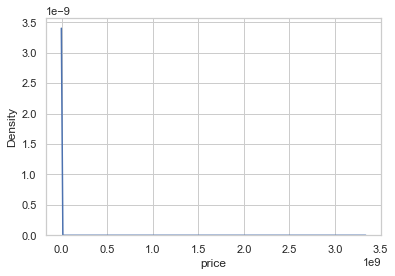

In [9]:
sns.kdeplot(data=train, x=target[0]);

Since, we can see here target is highly right skew, we need to analyze why? The quickest way is to see the make, model or 
description and see if there is something unusual with the data

In [10]:
train[train[target[0]]>1000000].head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,state,lat,long
4176,7108753879,https://yuma.craigslist.org/cto/d/somerton-198...,yuma,https://yuma.craigslist.org,11111111,1988.0,NaN,suzuki samurai,good,8 cylinders,gas,NaN,clean,automatic,NaN,4wd,NaN,offroad,black,https://images.craigslist.org/00Q0Q_7UZWnp0N9o...,Selling a 88 samari project with a 350 chevy m...,az,32.5634,-114.7130
8200,7111865892,https://westernmass.craigslist.org/cto/d/green...,western massachusetts,https://westernmass.craigslist.org,3500000,2020.0,honda,accord sport,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00O0O_a91q3PQDJF...,2020 Honda Accord Sport 1.5T for sale Messag...,ma,42.6013,-72.6236
14018,7109046695,https://evansville.craigslist.org/ctd/d/evansv...,evansville,https://evansville.craigslist.org,123456789,2005.0,jeep,wrangler,excellent,6 cylinders,gas,NaN,clean,other,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00v0v_XskwEB3yt6...,"I specialize in 2000 thru 2006 wranglers, I se...",in,38.0258,-87.5965
14460,7121060348,https://kpr.craigslist.org/cto/d/kennewick-196...,kennewick-pasco-richland,https://kpr.craigslist.org,2521176519,1964.0,volvo,544,NaN,NaN,gas,NaN,missing,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00g0g_8D26yYxQBW...,"28,354 miles on the odometer motor needs rebui...",wa,46.2109,-119.1680
19120,7117325706,https://memphis.craigslist.org/cto/d/eads-cash...,memphis,https://memphis.craigslist.org,1111111,1966.0,chevrolet,c10,NaN,NaN,gas,NaN,clean,manual,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00n0n_8CwhNDFkLv...,HAVE CASH TODAY FOR 1964-1966 CHEVROLET C10 SW...,tn,35.1551,-89.6760


In [11]:
train.loc[train['id']==7108753879, 'description'].values[0]

'Selling a 88 samari project with a 350 chevy motor has a mega 400 blower two 750 carbs,cam,rockers,valves,springs, pistons 30 over,etc.  Th 400 with shift kit,2.300 converter,manual valve body,bucket seats,9in ford diff with disc brakes Got a different project and dont have time for this one.  For info plz call or text me at  show contact info'

So, it looks like the most of the sellers post random/garbage value on the postings and this kind of spurious values will harm our analysis. In order to rectify this we will clip out the outlier using 3SD from IQR.

In [12]:
remove_outlier_price = remove_outlier.OutlierTrimmer(distribution='skewed', tail='right', fold=3)
print(f"Missing values in train target:{train[target].isna().sum()[0]}")
train['price'] = remove_outlier_price.fit_transform(train['price'].to_frame())
test['price'] = remove_outlier_price.transform(test['price'].to_frame())
print(f"Missing values in train target:{train[target].isna().sum()[0]}")


Missing values in train target:0
Missing values in train target:2696


In [13]:
# This is maximum non-spurious value comes out of outlier capping. Looks ok as there could be expensive new cars
remove_outlier_price.right_tail_caps_

{'price': 57260.0}

Null values were introduced due to dropping of dirty(high price) data

In [14]:
train = train.dropna(subset=target)
test = test.dropna(subset=target)

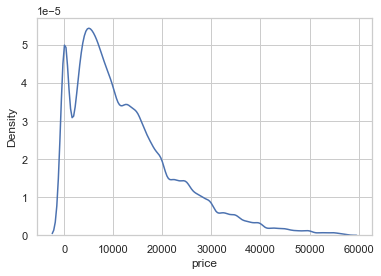

In [15]:
sns.kdeplot(data=train, x=target[0]);

Dropping dirty data from both since those spurious values don't represent actual vehicle

In [16]:
print(f"Minimum value in price/target: {train[target].min()[0]}")

Minimum value in price/target: 0.0


There are low values of price in our dataset and lets assume we only take data where price > 1,000. 

In [17]:
train = train[train[target[0]]>1_000].reset_index(drop=True).copy()
test = test[test[target[0]]>1_000].reset_index(drop=True).copy()

## Odometer analysis

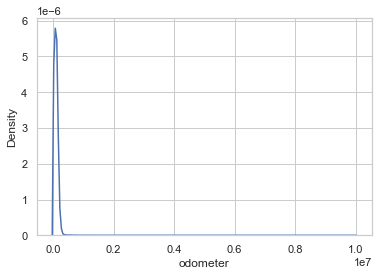

In [18]:
sns.kdeplot(data=train, x='odometer');

In [19]:
train[train['odometer']>1_000_000].head(2)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,state,lat,long
1569,7119835827,https://daytona.craigslist.org/cto/d/palm-coas...,daytona beach,https://daytona.craigslist.org,4000.0,2007.0,bmw,530i,good,6 cylinders,gas,1410000.0,clean,automatic,NaN,rwd,mid-size,sedan,silver,https://images.craigslist.org/00k0k_iaBekmtLd4...,2007 530i with 141k miles. Car runs and drives...,fl,29.5678,-81.2329
3445,7120832282,https://chico.craigslist.org/cto/d/oroville-20...,chico,https://chico.craigslist.org,6500.0,2012.0,ford,expidition,excellent,8 cylinders,gas,2000000.0,clean,automatic,NaN,NaN,NaN,NaN,black,https://images.craigslist.org/00G0G_1tbh1Z7MqP...,I have a very nice 2012 Ford Expidition for sa...,ca,39.4877,-121.4700


In [20]:
missing_data_impute_num = mdi.ArbitraryNumberImputer(arbitrary_number=-9999, variables=['odometer'])

train = missing_data_impute_num.fit_transform(train)
test = missing_data_impute_num.transform(test)


In [21]:
# all null values have been imputed by -9999
train['odometer'].isna().sum()

0

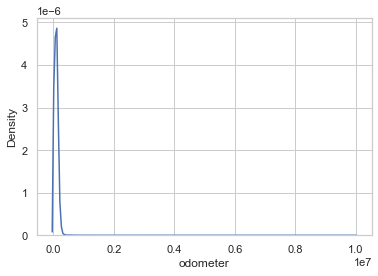

In [22]:
# Plot before outlier removal
sns.kdeplot(data=train, x= 'odometer');

In [23]:
remove_outlier_odometer = remove_outlier.OutlierTrimmer(distribution='skewed', tail='right', fold=3)

train['odometer'] = remove_outlier_odometer.fit_transform(train['odometer'].to_frame())
test['odometer'] = remove_outlier_odometer.transform(test['odometer'].to_frame())


train = train.dropna(subset=['odometer']).reset_index(drop=True)
test = test.dropna(subset=['odometer']).reset_index(drop=True)

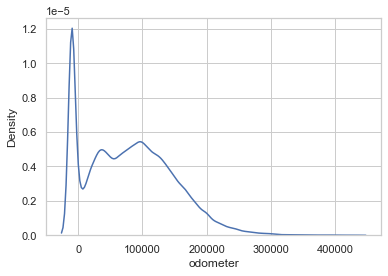

In [24]:
# PLot after outlier removal
sns.kdeplot(data=train, x= 'odometer');

In [25]:
print(f"train.shape:{train.shape}")
print(f"test.shape:{test.shape}")

train.shape:(309860, 24)
test.shape:(77413, 24)


## Check for duplicate ID

In [26]:
print(f"Train shape:{train.shape}")
print(f"Test shape:{test.shape}")

print(f"Number of duplicates in train: {len(train[train.duplicated()])}")
print(f"Number of duplicates in test: {len(test[test.duplicated()])}")

print(f"Unique id in train:{train['id'].nunique()}")
print(f"Unique id in test:{test['id'].nunique()}")

Train shape:(309860, 24)
Test shape:(77413, 24)
Number of duplicates in train: 0
Number of duplicates in test: 0
Unique id in train:309860
Unique id in test:77413


1. Since number of id is equal to number of observations it can be dropped.
2. We will drop url, region_url, image_url, lat, long, description(could be helpful to draw more insights) for now 

In [27]:
cols_to_drop = ['id', 'url', 'region_url', 'image_url', 'lat', 'long', 'description', 'region']

train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [28]:
print(f"Train shape before dup:{train.shape}")
print(f"Test shape before dup:{test.shape}")


print(f"Number of duplicates in train: {len(train[train.duplicated()])}")
print(f"Number of duplicates in test: {len(test[test.duplicated()])}")

# This duplicates arises because some vehicles were listed multiple times so they have multiple id's in the data. 
# Once we drop the id, all listing corresponding to a VIN becomes duplicate and therefore needs to be dropped. 
# Example VIN: WA1LAAF78HD040006

# Drop duplicate observations
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

print(f"Train shape after dedup:{train.shape}")
print(f"Test shape after dedup:{test.shape}")

Train shape before dup:(309860, 16)
Test shape before dup:(77413, 16)
Number of duplicates in train: 55130
Number of duplicates in test: 5100
Train shape after dedup:(254730, 16)
Test shape after dedup:(72313, 16)


## Correlation

In [29]:
train['vin'].value_counts()

NM0GE9E73G1278693    23
JM1NDAM74H0106020    23
5TDKZ3DC9KS018078    21
1FTFW1ET2EFA54776    20
00000000000000000    19
                     ..
5N1AZ2MS0KN105530     1
KNDJP3A55F7135891     1
1C4BJWEG6EL272864     1
5XYZHDAG1BG001349     1
1GCHK29295E202763     1
Name: vin, Length: 107463, dtype: int64

In [30]:
train.corr()['price'].to_frame()

,price
price,1.000000
year,0.300265
odometer,-0.282554


1. Positive correlation value of year makes sense as high value of year corresponds to higher price
2. Negative correlation value of odometer makes sense as higher value of odometer/mileage corresponds to lower price

## Extract categorical and numerical features

In [31]:
categorical_cols = train.select_dtypes(include='object').columns.tolist()
numerical_cols = train.select_dtypes(exclude='object').columns.tolist()

In [32]:
print(f"Categorical columns: {categorical_cols}\n")
print(f"Numerical columns: {numerical_cols}")

Categorical columns: ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'state']

Numerical columns: ['price', 'year', 'odometer']


In [33]:
train['vin'].value_counts()

NM0GE9E73G1278693    23
JM1NDAM74H0106020    23
5TDKZ3DC9KS018078    21
1FTFW1ET2EFA54776    20
00000000000000000    19
                     ..
5N1AZ2MS0KN105530     1
KNDJP3A55F7135891     1
1C4BJWEG6EL272864     1
5XYZHDAG1BG001349     1
1GCHK29295E202763     1
Name: vin, Length: 107463, dtype: int64

In [34]:
train[train['vin']=='NM0GE9E73G1278693']

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,state
9853,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,vt
23232,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,ny
26072,26500.0,2016.0,NaN,Mini-t Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,va
31201,26500.0,2016.0,NaN,Mini-T Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,NaN,NaN,van,NaN,wa
31547,26500.0,2016.0,NaN,Mini-T Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,tx
50442,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,md
88044,26500.0,2016.0,mini,t campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,mi
104090,26500.0,2016.0,NaN,Mini-T Campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,NaN,NaN,van,NaN,il
111557,26500.0,2016.0,NaN,Transit Connect CamperVan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,oh
119746,26500.0,2016.0,mini,campervan,excellent,4 cylinders,gas,69050.0,clean,automatic,NM0GE9E73G1278693,fwd,NaN,van,NaN,ia


We can see here duplicate vin corresponds to duplicate listings to increase the probability of selling the vehicle. For training, it is not a good idea to keep duplicate vins so we will keep one of all duplicate records. We can keep the duplicate in test data since duplicate affects the training not prediction. Also, in real life scenario we can expect duplicates.

In [35]:
train = train.drop_duplicates(subset=['vin'], keep='first').reset_index(drop=True)

In [36]:
train['vin'].isna().sum()

1

In [37]:
train = train.drop(columns='vin')
test = test.drop(columns='vin')

## Lets evaluate vin & cylinders

In [38]:
train.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,17993.0,2014.0,ram,1500 express rwd gas,NaN,NaN,gas,34726.0,clean,automatic,rwd,NaN,truck,blue,wa
1,5999.0,2013.0,ford,focus,excellent,4 cylinders,gas,84381.0,clean,automatic,fwd,compact,sedan,NaN,oh
2,3000.0,2018.0,NaN,Yamaha TTR 230,excellent,NaN,gas,-9999.0,clean,manual,NaN,NaN,offroad,blue,ak
3,2500.0,2002.0,audi,a8l quattro,excellent,8 cylinders,gas,204000.0,salvage,automatic,4wd,full-size,sedan,blue,nj
4,7995.0,2009.0,honda,accord,NaN,4 cylinders,gas,117630.0,clean,automatic,fwd,NaN,sedan,grey,oh


In [39]:
# class Preprocessing(BaseEstimator, TransformerMixin):
#     """
#     Simple transformer to indicate if vin is present or not. If present then 1 else 0
#     """
#     def __init__(self):
#         pass
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X, y=None):
#         X = X.copy()
#         X.loc[X['vin'].isna(), 'vin']=0
#         X.loc[~X['vin'].isna(), 'vin']=1
# #         X['cylinders'] = X['cylinders'].str.replace('cylinders','')
# #         X.loc[X['cylinders']=='other', 'cylinders'] = '99'
#         X['vin'] = X['vin'].astype('int')
#         return X

In [40]:
# ppr  = Preprocessing()

# train = ppr.fit_transform(train)
# test = ppr.transform(test)

## Box Plot

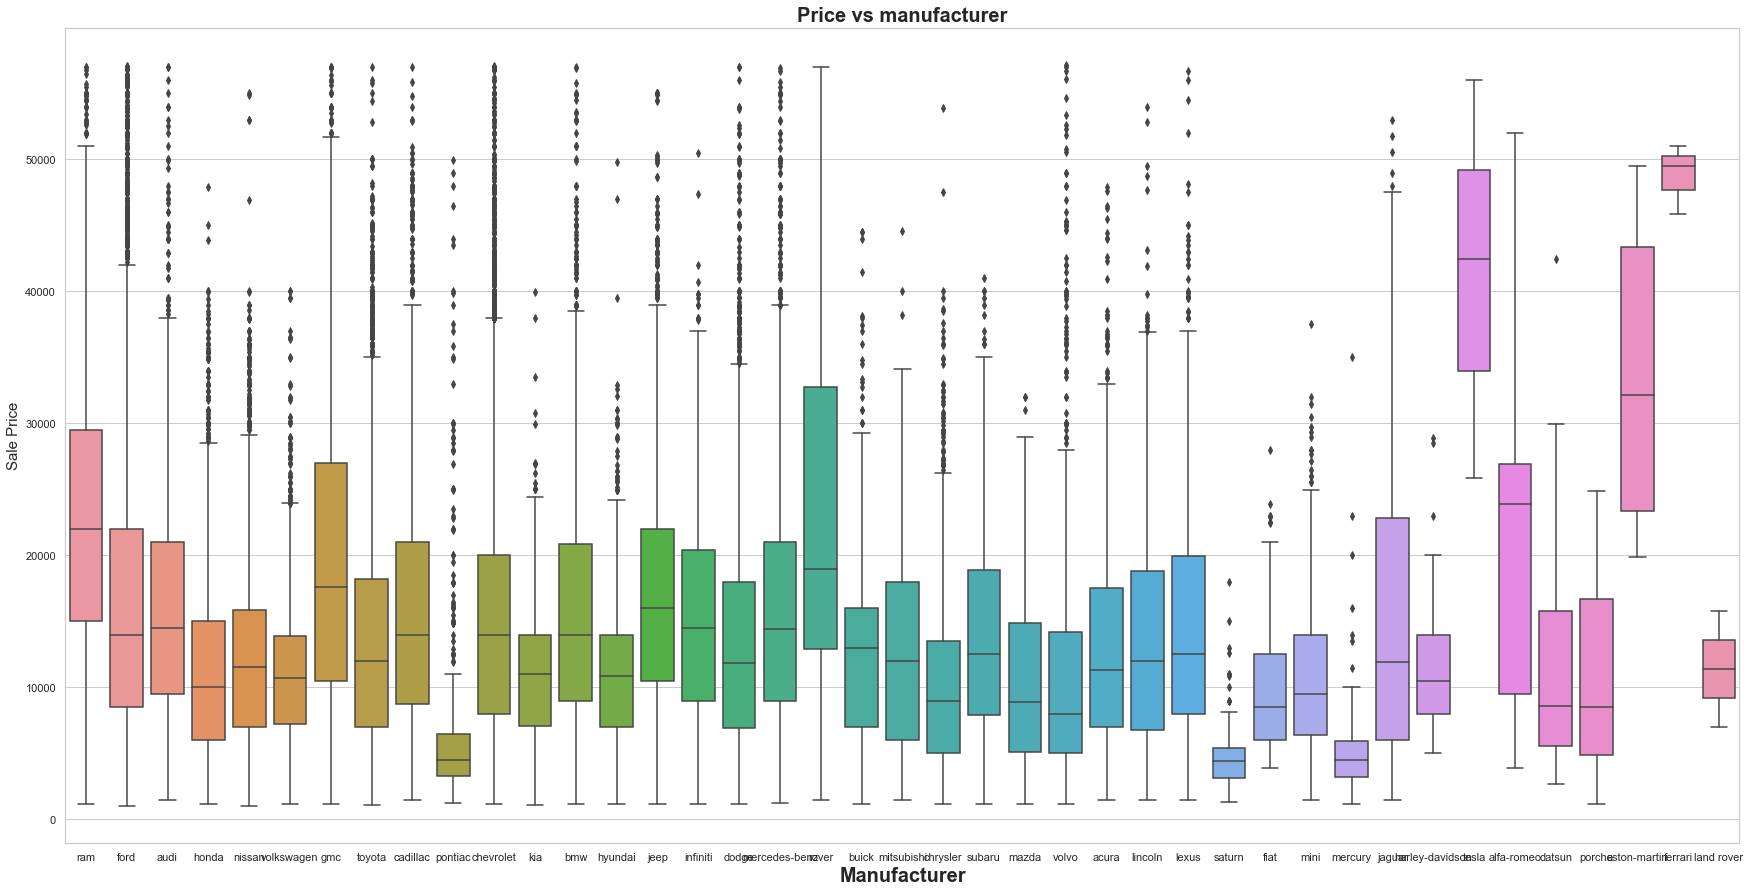

In [41]:
plt.figure(figsize=(30,15))
sns.boxplot(y=target[0], x='manufacturer', data= train)
plt.title("Price vs manufacturer", fontsize=20,fontweight='bold')
plt.xlabel("Manufacturer", fontsize=20,fontweight='bold')
plt.ylabel("Sale Price", fontsize=15)
plt.show()

## Pair plot

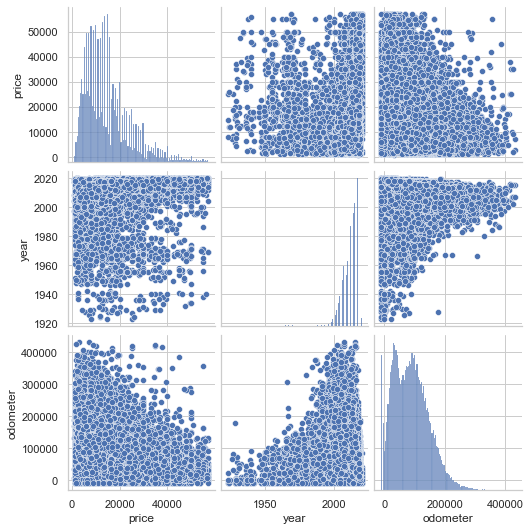

In [42]:
sns.pairplot(data=train[numerical_cols]);

## Regresion plot

In [43]:
numerical_cols

['price', 'year', 'odometer']

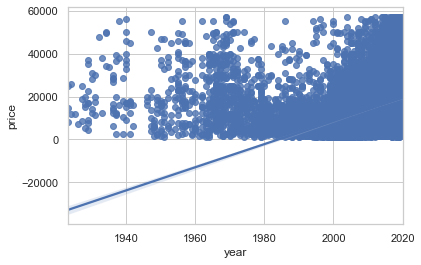

In [44]:
sns.regplot(x=train["year"], y=train["price"], scatter= True, fit_reg= True);

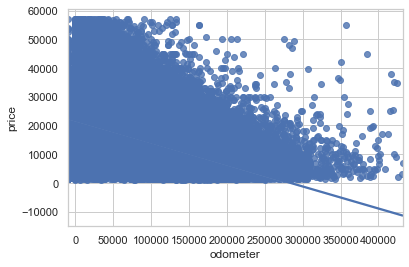

In [45]:
sns.regplot(x=train["odometer"], y=train["price"], scatter= True, fit_reg= True);

## Scatter plot

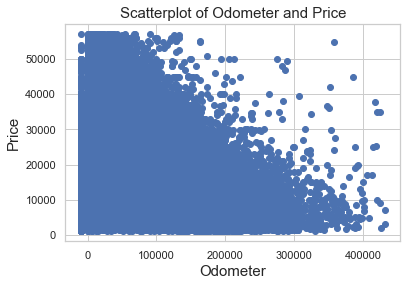

In [46]:
plt.title("Scatterplot of Odometer and Price", fontsize=15)
plt.xlabel("Odometer", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.scatter(x= train.odometer, y= train.price);

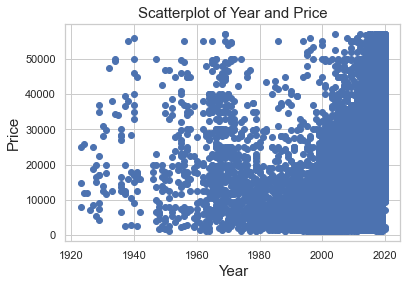

In [47]:
plt.title("Scatterplot of Year and Price", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.scatter(x= train.year, y= train.price);

## Categorical variables plot

In [48]:
categorical_cols

['manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'vin',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

# Count plot

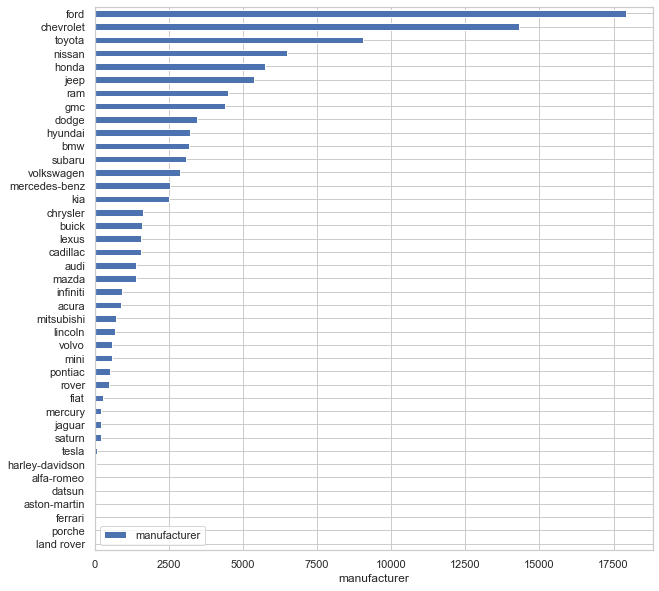

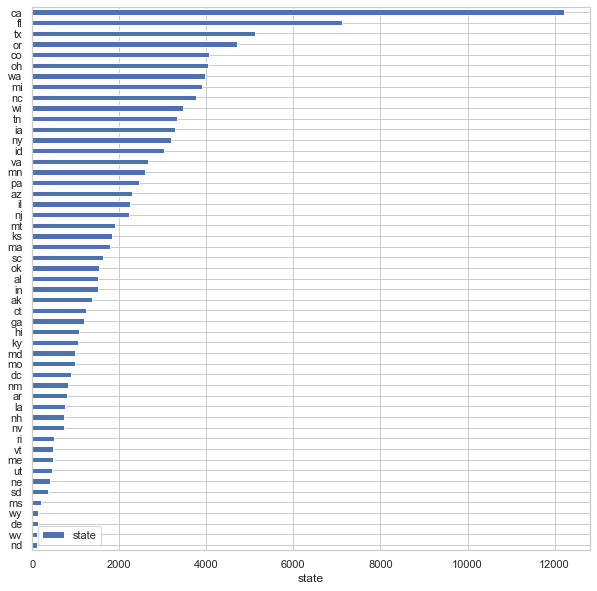

In [49]:
for col in ['manufacturer', 'state']:
    train[col].value_counts().sort_values().to_frame().plot(kind='barh', figsize=(10,10))
    plt.xlabel(f"{col}")

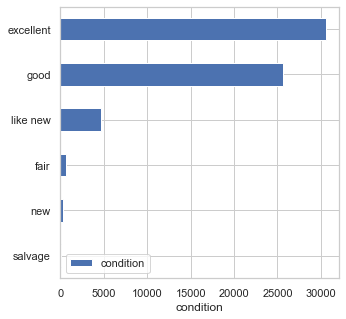

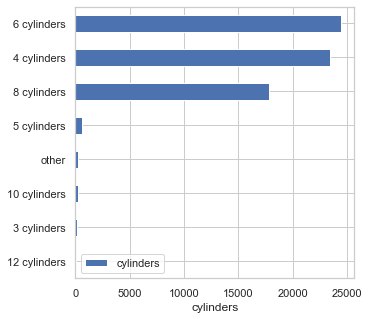

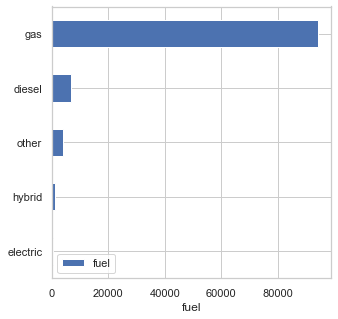

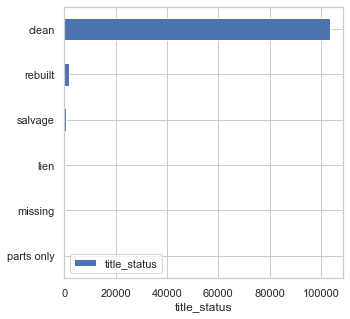

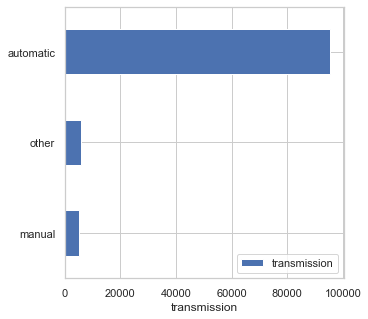

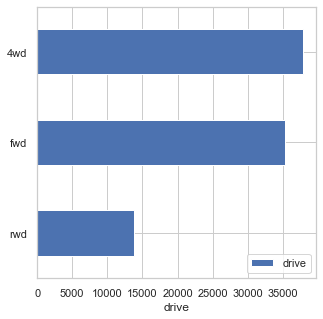

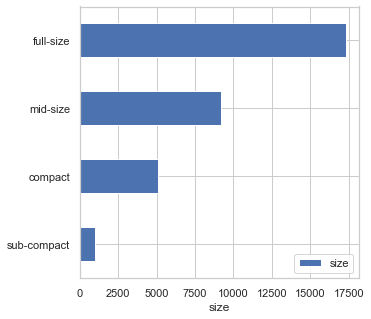

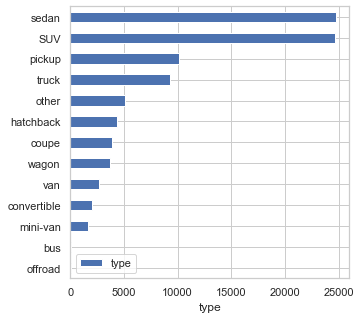

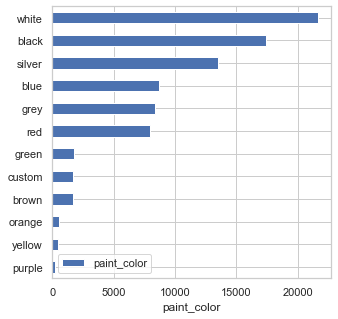

In [50]:
for col in categorical_cols:
    if col not in ['manufacturer', 'model', 'vin', 'state']:
        train[col].value_counts().sort_values().to_frame().plot(kind='barh', figsize=(5,5))
        plt.xlabel(f'{col}')
        plt.show()

In [51]:
train['model'].nunique()

15238

No plot for model because it has 15,238 values and it will consume a lot of space and time to generate plot

## Impute missing values

In [52]:
train.isna().mean()

price           0.000000
year            0.003527
manufacturer    0.029052
model           0.006011
condition       0.422960
cylinders       0.376154
fuel            0.011985
odometer        0.000000
title_status    0.007295
transmission    0.008915
drive           0.191767
size            0.696959
type            0.139014
paint_color     0.217440
state           0.000000
dtype: float64

In [53]:
# Impute numerical columns
missing_data_impute_num = mdi.ArbitraryNumberImputer(arbitrary_number=-9999, variables=['year'])
train = missing_data_impute_num.fit_transform(train)
test = missing_data_impute_num.transform(test)

In [54]:
# Impute categorical columns
missing_data_impute_cat = mdi.CategoricalVariableImputer(imputation_method='missing', fill_value='missing')
train = missing_data_impute_cat.fit_transform(train)
test = missing_data_impute_cat.transform(test)

## Categorical Variable Encoding

In [55]:
rl1 = ce.RareLabelCategoricalEncoder(tol=0.01, variables=['manufacturer'], n_categories=5, replace_with='rare')

rl2 = ce.RareLabelCategoricalEncoder(tol=0.01, variables=['cylinders'], n_categories=5,replace_with='-1')

rl3 = ce.RareLabelCategoricalEncoder(tol=0.07, variables=['condition'], replace_with='rare', n_categories=3)

rl4 = ce.RareLabelCategoricalEncoder(tol=0.04, variables=['type'], replace_with='rare', n_categories=3)

rl5 = ce.RareLabelCategoricalEncoder(tol=0.05, variables=['paint_color'], replace_with='rare',n_categories=3)

rl6 = ce.RareLabelCategoricalEncoder(tol=0.05, variables=['transmission'], replace_with='rare', n_categories=3)

## Create a pipeline

In [56]:
pipeline_ =[]

pipeline_.append(('rl1', rl1))
pipeline_.append(('rl2', rl2))
pipeline_.append(('rl3', rl3))
pipeline_.append(('rl4', rl4))
pipeline_.append(('rl5', rl5))
pipeline_.append(('rl6', rl6))

transform_pipeline = Pipeline(pipeline_)

In [57]:
# Dropping model column because this is the most dirty column, need extra cleaning, will be released in next version
cols_to_drop_2 = ['model']
train = train.drop(columns=cols_to_drop_2)
test = test.drop(columns=cols_to_drop_2)

In [58]:
# Transform the train and test data 
train = transform_pipeline.fit_transform(train)
test = transform_pipeline.transform(test)

In [59]:
# cat_encode = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency')
# train_ = cat_encode.fit_transform(train_)
# test_ = cat_encode.transform(test_)

## MEstimate Encoder for categorical variables

In [61]:
train.dtypes

price           float64
year            float64
manufacturer     object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object

In [62]:
target = ['price']
numerical_cols = ['odometer', 'year']
categorical_cols = [col for col in train.columns if col not in target+numerical_cols]

In [63]:
len(train.columns), len(numerical_cols), len(categorical_cols), len(target)

(14, 2, 11, 1)

In [64]:
target

['price']

In [65]:
numerical_cols

['odometer', 'year']

In [66]:
categorical_cols

['manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [67]:
mee_encode = MEstimateEncoder(random_state=config.RANDOM_STATE, m=50)
train[categorical_cols] = mee_encode.fit_transform(X=train[categorical_cols], y=train[target])
test[categorical_cols] = mee_encode.transform(test[categorical_cols])

c:\users\steja\anaconda3\envs\used_car_price\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [69]:
train.shape, test.shape

((107464, 14), (72313, 14))

In [70]:
train[categorical_cols].head()

,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
0,22864.236634,16939.351838,16034.412539,14173.712014,15046.623825,14876.908800,14973.502750,15984.544266,20613.105653,13163.924260,20127.854820
1,16231.908997,13171.468288,10893.619659,14173.712014,15046.623825,14876.908800,10932.199730,9802.623965,11029.507360,15413.974279,12598.460745
2,17508.991073,13171.468288,16034.412539,14173.712014,15046.623825,13614.445436,15186.183642,15984.544266,13734.793749,13163.924260,21619.714364
3,16252.918289,13171.468288,18686.309610,14173.712014,11517.217921,14876.908800,18599.718749,14371.663020,11029.507360,13163.924260,12176.249860
4,11356.157105,16939.351838,10893.619659,14173.712014,15046.623825,14876.908800,10932.199730,15984.544266,11029.507360,13908.729114,12598.460745


# Models

## 1. Linear Regression

### Check Multi collinearity

In [71]:
def calc_vif(X: pd.DataFrame) -> pd.DataFrame:

    # Calculate VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(['VIF'], ascending=False).reset_index(drop=True)

    return(vif)

In [73]:
calc_vif(train)

,variables,VIF
0,title_status,370.119339
1,transmission,299.601678
2,paint_color,118.544280
3,condition,81.900117
4,size,79.877460
5,state,55.212561
6,cylinders,47.958465
7,fuel,44.181029
8,manufacturer,40.521355
9,type,38.908493


In [74]:
train.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,17993.0,2014.0,22864.236634,16939.351838,16034.412539,14173.712014,34726.0,15046.623825,14876.908800,14973.502750,15984.544266,20613.105653,13163.924260,20127.854820
1,5999.0,2013.0,16231.908997,13171.468288,10893.619659,14173.712014,84381.0,15046.623825,14876.908800,10932.199730,9802.623965,11029.507360,15413.974279,12598.460745
2,3000.0,2018.0,17508.991073,13171.468288,16034.412539,14173.712014,-9999.0,15046.623825,13614.445436,15186.183642,15984.544266,13734.793749,13163.924260,21619.714364
3,2500.0,2002.0,16252.918289,13171.468288,18686.309610,14173.712014,204000.0,11517.217921,14876.908800,18599.718749,14371.663020,11029.507360,13163.924260,12176.249860
4,7995.0,2009.0,11356.157105,16939.351838,10893.619659,14173.712014,117630.0,15046.623825,14876.908800,10932.199730,15984.544266,11029.507360,13908.729114,12598.460745


In [75]:
train.shape

(107464, 14)

In [76]:
models = []
models.append(('Linear Regression', LinearRegression()))
# models.append(('SVR',SVR()))
# models.append(('KNN', KNeighborsRegressor()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('XGBoost', XGBRegressor()))

In [77]:
train_y = train[target]
test_y = test[target]

train_X = train.drop(columns=target)
test_X = test.drop(columns=target)

In [78]:
ss = StandardScaler()

train_X = pd.DataFrame(ss.fit_transform(train_X), columns=train_X.columns.tolist())
test_Y = pd.DataFrame(ss.transform(test_X), columns=test_X.columns.tolist())


In [79]:
train_X.columns

Index(['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object')

In [80]:
for name, model in models:
    
    scores = cross_validate(estimator=model, 
                        X=train_X, 
                        y=train_y.values.ravel(), 
                        cv=5,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True,
                        return_estimator=True)
    
    print(f"{name} train r2: {round(scores['train_r2'].mean()*100,1)}")
    print(f"{name} valid r2: {round(scores['test_r2'].mean()*100,1)}")
    

Linear Regression train r2: 51.7
Linear Regression valid r2: 51.5
Decision Tree train r2: 99.9
Decision Tree valid r2: 56.7
Random Forest train r2: 96.9
Random Forest valid r2: 78.3
XGBoost train r2: 83.7
XGBoost valid r2: 79.2


In [ ]:
    # # experiment_id = mlflow.create_experiment(name='train')
    # with mlflow.start_run():
    #     scores = _cross_validate_pipeline(df=train)
    #     mlflow.log_metric("train r2", round(scores['train_r2'].mean() * 100, 1))
    #     mlflow.log_metric("valid r2", round(scores['test_r2'].mean() * 100, 1))
    #     # mlflow.log_metric("train rmse", round(np.sqrt(scores['train_neg_mean_squared_error'].mean() * 100, 1)))
    #     # mlflow.log_metric("valid rmse", round(np.sqrt(scores['test_neg_mean_squared_error'].mean() * 100, 1)))

In [81]:
# import xgboost
# import shap

# # load JS visualization code to notebook
# shap.initjs()

# # train XGBoost model
# X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# # explain the model's predictions using SHAP
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)

# # summarize the effects of all the features
# shap.summary_plot(shap_values, X)

In [ ]:
X